# Evaluating Image to Text Models


## Apple VQG

In [13]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from src.evaluation.eval_main import Metrics

folder_path = "../../../eval_results/apple_vqg"

In [ ]:
gt_df = pd.read_csv(os.path.join(folder_path, "224x224-dense-glove-greedy-image-only-goldstandard-v2/gt_apple_vqg_test.csv"))
res_df = pd.read_csv(os.path.join(folder_path, "224x224-dense-glove-greedy-image-only-goldstandard-v2/result_apple_vqg_test.csv"))
gt_df

In [ ]:
res_df

## Explaining the model names

### Apple VQG
- All the following concepts have to be explained / layed out
- original paper: [ref](https://arxiv.org/pdf/2012.03678.pdf)
- Supports multiple different image encoders, resolutions and inputs
- first part: resolution, e.g. 224x224
- second part: Image Encoders:
    - dense: DenseNet [ref](https://arxiv.org/abs/1608.06993)
    - vgg19: VGG19 [ref](https://arxiv.org/abs/1608.06993)
    - They are initialized from pre-trained weights from the model hub -> Trained on COCO / ImageNet
    - Used them because they showed the best performance in the paper and were the default setting for the released model src code
- third part: Embedding strategy:
    - I only used the Glove embeddings as they performed the best in the original apple paper
- fourth part: inputs:
    - Image only: No further text input only the image encoder as context
    - Keywords: Image and Keyword input, in our case, keyword = title of the slide
- fifth part: decoding strategy:
    - greedy: Always select the token with the highest probability [ref](https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24)
    - sbs: Simple Beam Search: [ref](https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24)
- The LSTMs are initialized without pre-trained weights and are trained from scratch, as the apple guys didn't release any pre-trained weights
- Model sketch: (the one in the paper is misleading)
![Apple VQG sketch](Ankinator%20Concept-4.jpg)

- Model is trained with different configurations:
- DenseNet and VGG19 to see if different image encoder architectures might cope better with the slide data or can be fine-tuned faster to yield meaningful encodings
- Different Decoding Schemes: Greedy and Simple Beam Search
    - Using Beam Search takes significantly longer, but in theory should yield a better performance as the result sequence is evaluated and not the probability of the individual tokens
- With Keywords and without, to capture the impact of feeding keywords to the model
- With the original resolution of 224x224 because thats what the models have been pretrained for and what the model was originally proposed with
    - This was expected to yield bad performance numbers as text is very sensitive to resolution -> show this with an example where a high res image and a low res one are side by side and point out visual differences
- And in fhd, as it is returned by the extractor to solve the resolution issue

## Visualizing the number of NaN Values the model produces
- Visualize the number of NaN values produced per model
- The model producing NaN = No output / it only produced an \<end>-token -> No question has been generated

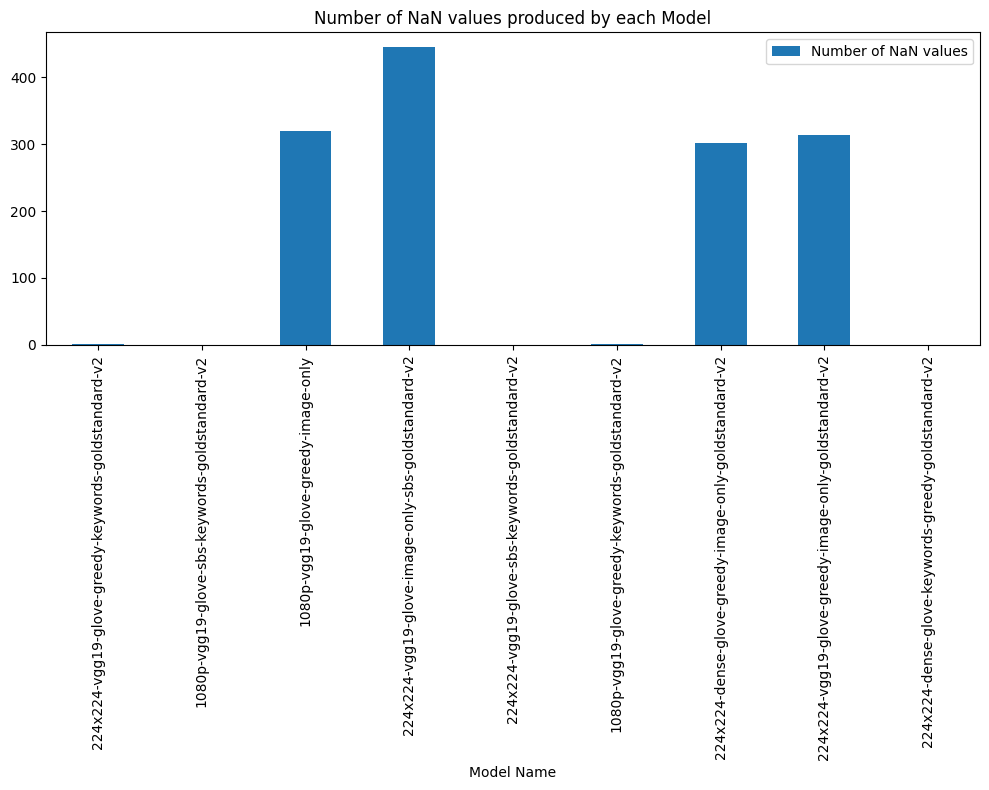

In [17]:
from collections import defaultdict

dir_content = os.listdir(folder_path)
#dir_content.remove(".DS_Store")

nan_cnts = defaultdict(list)

for folder in dir_content:
    tmp_res_df = pd.read_csv(
        os.path.join(
            os.path.join(folder_path, folder),
            "result_apple_vqg_test.csv"
        )
    )
    nan_cnts["model_name"].append(folder)
    nan_cnts["counts"].append(tmp_res_df.questions.isnull().sum())

pd.DataFrame(nan_cnts).plot(kind='bar', x="model_name", figsize=(10, 8))
plt.title('Number of NaN values produced by each Model')
plt.xlabel("Model Name")
plt.legend(["Number of NaN values"])
plt.tight_layout()
plt.savefig("plots/number_nan_values.png", dpi=150)
plt.show()

- Using Greedy or Simple Beam Search (sbs) makes no difference in the number of NaN values produced by the model
- Using a higher resolution also doesn't improve the number of NaN values
- However, enabling the use of Keywords as input, drastically reduces the number of cases where the model produces NaN values
    - Number of NaN values is then almost 0
    - The Image Encoder seemed to have no effect for the resolution of 224x224, combined with the fact that keywords drastically influence the number of produced outputs, it shows that the image encoder produces no usable information at this resolution
    - I'd add an example from the extracted image and the rescaled image at some point into the report, as it is important for both vit-gpt2 and the apple_vqg model

## Applying evaluation

In [ ]:
dir_content = os.listdir(folder_path)
#dir_content.remove(".DS_Store")

overall = pd.DataFrame()

for folder in dir_content:
    # read ground truth
    gt_df = pd.read_csv(
        os.path.join(
            os.path.join(folder_path, folder),
            "gt_apple_vqg_test.csv"
        )
    )
    # read model outs
    res_df = pd.read_csv(
        os.path.join(
            os.path.join(folder_path, folder),
            "result_apple_vqg_test.csv"
        )
    )
    # convert multiple reference format of the apple model to list
    gt_df["questions"] = gt_df.questions.apply(lambda str: str.split("---"))

    # build reference data representation
    refs = []
    for idx, row in gt_df.iterrows():
        refs.append((row.image_id, row.questions))

    # build model output representation
    model_outs = []
    res_df["questions"] = res_df.questions.fillna("") # change nan to empty string, as nan is a floating value
    for idx, row in res_df.iterrows():
        model_outs.append((row.image_id, [row.questions]))

    # run evaluation
    metrics = Metrics(save_to_file=True)
    result = pd.DataFrame(
        metrics.evaluate(model_output=model_outs, references=refs),
        index=[folder]
    )
    result.to_csv("out/eval/result.csv")

    overall = pd.concat([overall, result])

    # copy results to correct folder
    os.system(f"mv out/eval/* {os.path.join(folder_path, folder)}")

In [ ]:
overall

## Evaluation Metrics

### Similiarity

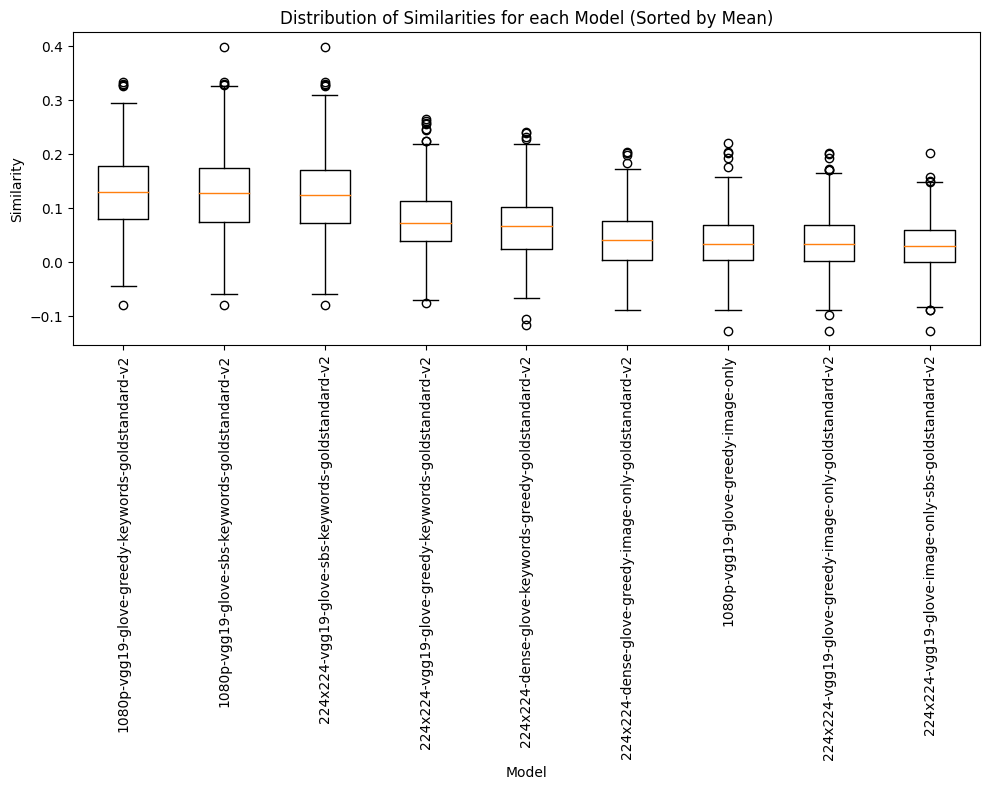

In [18]:
# Initialize a list to store the similarity data for each model
similarity_data = []
model_names = []

# Iterate through the subfolders in the main folder
for root, dirs, files in os.walk(folder_path):
    for dir_name in dirs:
        subfolder_path = os.path.join(root, dir_name)
        csv_path = os.path.join(subfolder_path, "cosine_sim.csv")

        # Check if the cosine_sim.csv file exists in the subfolder
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            similarity_data.append(df['max_similarity'])
            model_names.append(dir_name)

mean_similarities = [np.mean(data) for data in similarity_data]

# Sort the data and mean similarities in descending order
sort_indices = np.argsort(mean_similarities)[::-1]
sorted_similarity_data = [similarity_data[i] for i in sort_indices]
sorted_model_names = [model_names[i] for i in sort_indices]
sorted_mean_similarities = [mean_similarities[i] for i in sort_indices]

# Plotting the boxplot
plt.figure(figsize=(10,8))
plt.boxplot(sorted_similarity_data, labels=sorted_model_names)
plt.xlabel("Model")
plt.ylabel("Similarity")
plt.title("Distribution of Similarities for each Model (Sorted by Mean)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("plots/apple_vqg_cosine_sim_boxplot.png", dpi=150)
plt.show()

- Compare the distribution between the different configs, main takeaways are:
- keyword input performs better than just image input
- the distribution is quite spread / dispersed for every config
- beam search can improve the performance but not in all cases -> it improved for res: 224x224, image enc: vgg19 with keyword input, but didn't perform better in all other test cases
- Increasing the resolution also didn't increase the performance

### Meteor

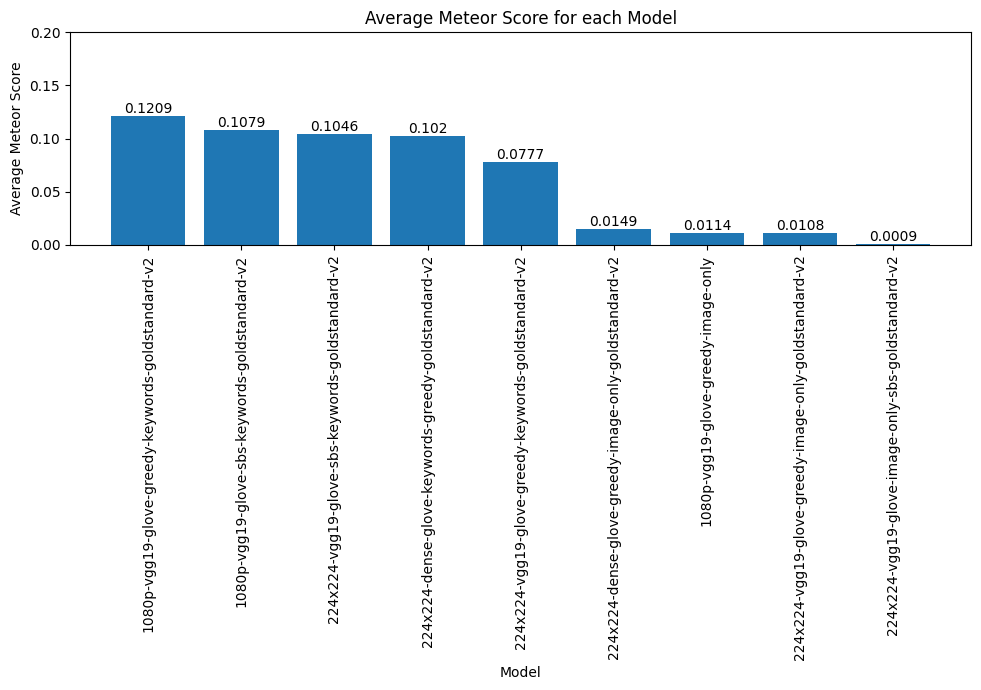

In [19]:
model_names = []
average_similarities = []

# Iterate through the subfolders in the main folder
for root, dirs, files in os.walk(folder_path):
    for dir_name in dirs:
        subfolder_path = os.path.join(root, dir_name)
        csv_path = os.path.join(subfolder_path, "sem_meteor.csv")

        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            average_similarity = df['max_sem_meteor'].mean()
            model_names.append(dir_name)
            average_similarities.append(average_similarity)

sort_indices = np.argsort(average_similarities)[::-1]
sorted_model_names = [model_names[i] for i in sort_indices]
sorted_average_similarities = [average_similarities[i] for i in sort_indices]

# Plotting the bar chart
plt.figure(figsize=(10,7))
plt.bar(sorted_model_names, sorted_average_similarities)
plt.xlabel("Model")
plt.ylabel("Average Meteor Score")
plt.title("Average Meteor Score for each Model")
plt.xticks(rotation=90)
# Add numerical values to each bar
for i, v in enumerate(sorted_average_similarities):
    plt.text(i, v, str(round(v, 4)), ha="center", va="bottom")

plt.ylim(0, 0.2)

plt.tight_layout()
plt.savefig("plots/apple_vqg_meteor_barplot.png", dpi=150)
plt.show()

- Semantic Meteor shows the same picture as with semantic similarity
- describe it very briefly

### F1

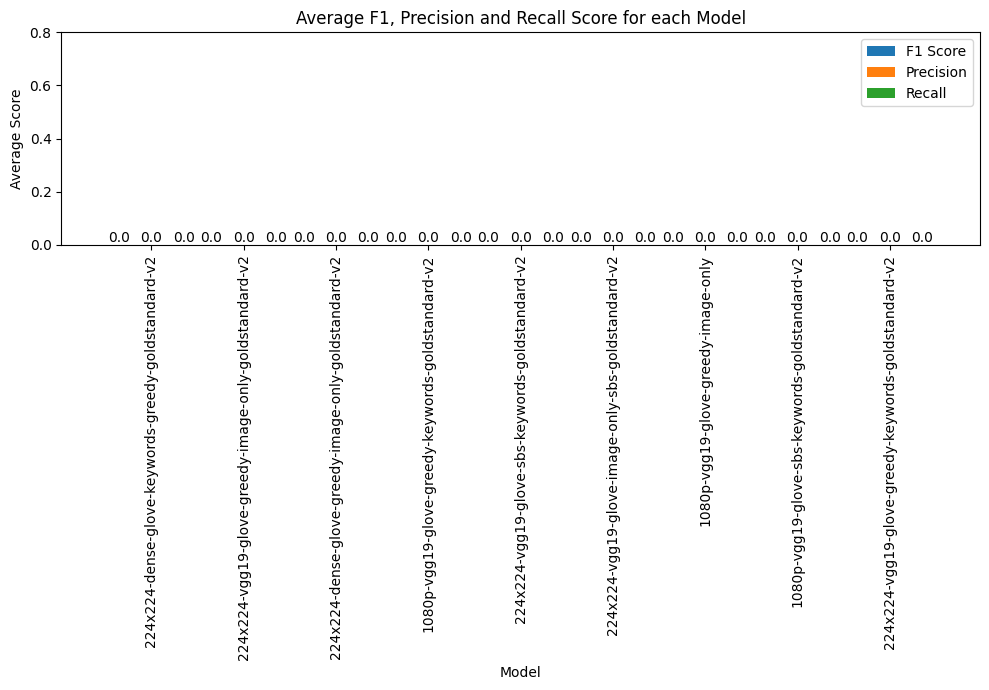

In [20]:
model_names = []
average_similarities = []
avg_ps = []
avg_rs = []

# Iterate through the subfolders in the main folder
for root, dirs, files in os.walk(folder_path):
    for dir_name in dirs:
        subfolder_path = os.path.join(root, dir_name)
        csv_path = os.path.join(subfolder_path, "traditional_scores.csv")

        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            average_similarity = df['max_f1'].mean()
            avg_p = df['max_p'].mean()
            avg_r = df['max_r'].mean()
            model_names.append(dir_name)
            average_similarities.append(average_similarity)
            avg_ps.append(avg_p)
            avg_rs.append(avg_r)

sort_indices = np.argsort(average_similarities)[::-1]
sorted_model_names = [model_names[i] for i in sort_indices]
sorted_average_similarities = [average_similarities[i] for i in sort_indices]
sorted_average_p = [avg_ps[i] for i in sort_indices]
sorted_average_r = [avg_rs[i] for i in sort_indices]

bar_width = 0.35
index = np.arange(len(sorted_model_names))

# Plotting the bar chart
plt.figure(figsize=(10,7))
plt.bar(index, sorted_average_similarities, bar_width, label="F1 Score")
plt.bar(index + bar_width, sorted_average_p, bar_width, label="Precision")
plt.bar(index - bar_width, sorted_average_r, bar_width, label="Recall")
plt.xlabel("Model")
plt.ylabel("Average Score")
plt.title("Average F1, Precision and Recall Score for each Model")
plt.xticks(index, sorted_model_names, rotation=90)
# Add numerical values to each bar
for i, v in enumerate(sorted_average_similarities):
    plt.text(i, v, str(round(v, 4)), ha="center", va="bottom")

for i, v in enumerate(sorted_average_p):
    plt.text(i + bar_width, v, str(round(v, 4)), ha="center", va="bottom")

for i, v in enumerate(sorted_average_r):
    plt.text(i - bar_width, v, str(round(v, 4)), ha="center", va="bottom")

plt.ylim(0, 0.8)

plt.tight_layout()
plt.legend()
plt.savefig("plots/apple_vqg_traditional_scores_f1_barplot.png", dpi=150)
plt.show()

- In terms of F1, Precision and Recall, all models achieved a Score of 0, showing that there is no meaningful overlap between the references and the model outputs

## Conclusion

- Models with keyword input performed a lot better than models without keyword input
- Simple Beam Search didn't yield better results, as the decoding strategy doesn't seem to be the bottleneck
- All models didn't perform at all in all metrics, with higher resolution keyword models showing the best performance
- Show model output examples of best model config and worst model config
- That shows that the decoder learned to produce a meaningful and good beginning of the question but the context seems to be missing as everything afterwards is basically rubbish
- The performance difference between the inclusion of keywords and no keywords hints at the fact that the image encoder is the bottle-neck of the architecture
- Even higher resolutions couldn't improve the results, showing that the resolution is in fact not the limiting factor at the moment
- Instead, the problem is the difference in training data for the image-encoder during pre-training and our data. Both models have been trained on Images of common objects and not texts or info graphics. We thus hypothesize, that the difference between the pre-trained weights and the theoretical optimal weights for our task is too large, and that our training procedure isn't sufficient to overcome this gap. Thus, it might be useful to retrain the image encoder from scratch with more data in a good pre-training task for future work. (Maybe also find a reference or an example that shows that visual understanding of textual content is difficult, even today?)

# ViT-GPT-2
- See Vit-GPT-2 notebook for model infos
- The model was implemented using beam search decoding scheme


In [25]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from src.evaluation.eval_main import Metrics

folder_path = "../../../eval_results/vit-gpt2"

## Number of NaN Values
- Because of ViT-GPT-2 strong GPT-2 based decoder, it didn't produce any NaN values.

## Evaluation Metrics

### Similarity


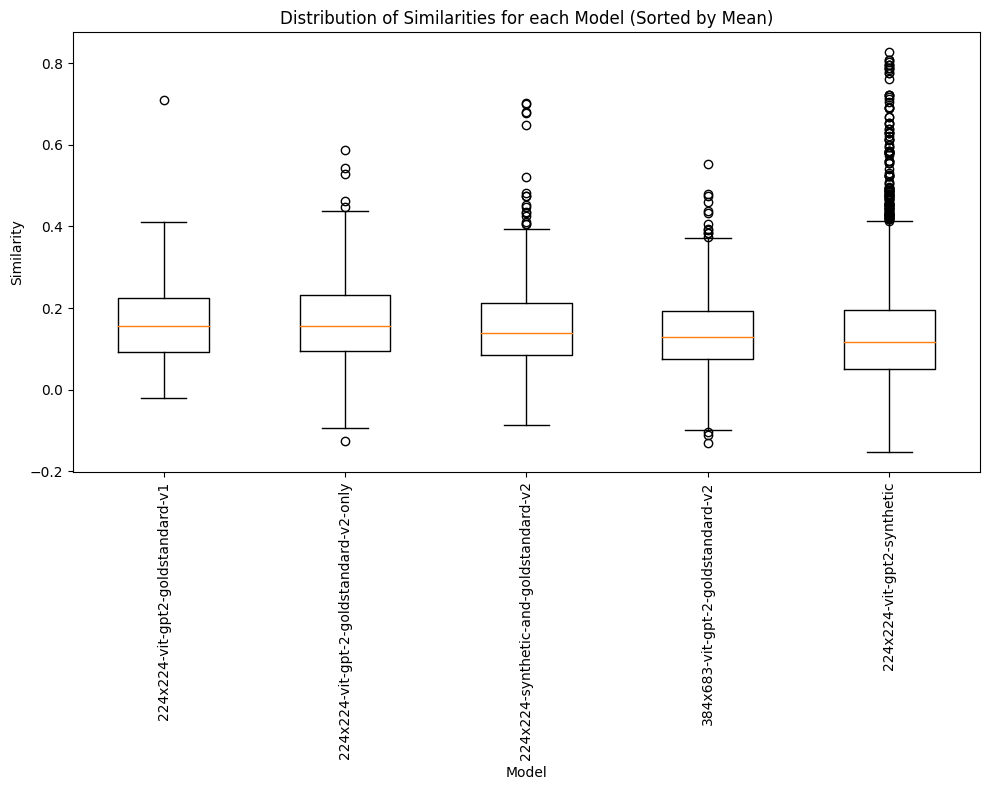

In [26]:
# Initialize a list to store the similarity data for each model
similarity_data = []
model_names = []

# Iterate through the subfolders in the main folder
for root, dirs, files in os.walk(folder_path):
    for dir_name in dirs:
        subfolder_path = os.path.join(root, dir_name)
        csv_path = os.path.join(subfolder_path, "cosine_sim.csv")

        # Check if the cosine_sim.csv file exists in the subfolder
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            model_names.append(dir_name)
            similarity_data.append(df['similiarities'])

mean_similarities = [np.mean(data) for data in similarity_data]

# Sort the data and mean similarities in descending order
sort_indices = np.argsort(mean_similarities)[::-1]
sorted_similarity_data = [similarity_data[i] for i in sort_indices]
sorted_model_names = [model_names[i] for i in sort_indices]
sorted_mean_similarities = [mean_similarities[i] for i in sort_indices]

# Plotting the boxplot
plt.figure(figsize=(10,8))
plt.boxplot(sorted_similarity_data, labels=sorted_model_names)
plt.xlabel("Model")
plt.ylabel("Similarity")
plt.title("Distribution of Similarities for each Model (Sorted by Mean)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("plots/vit_gpt_cosine_sim_boxplot.png", dpi=150)
plt.show()

- Again compare distributions a bit between configurations
- All performed very similar
- Increasing the resolution didn't yield a performance increase
- Distributions are very dispersed, and have a lot of outliers towards the positive end of the scale, especially the model trained on the synthetic slides
    - That the synthetic slides have so many outliers could be related to the different question formats, as they include a lot of "Lückentexte", where the keywords are missing, as a result, the S-Bert model is then fooled into predicting a similarity based on the construction of the sentence and the surrounding context of the missing keywords. These contexts however, are often similar and could thus lead to a higher overall similar score.

### Meteor

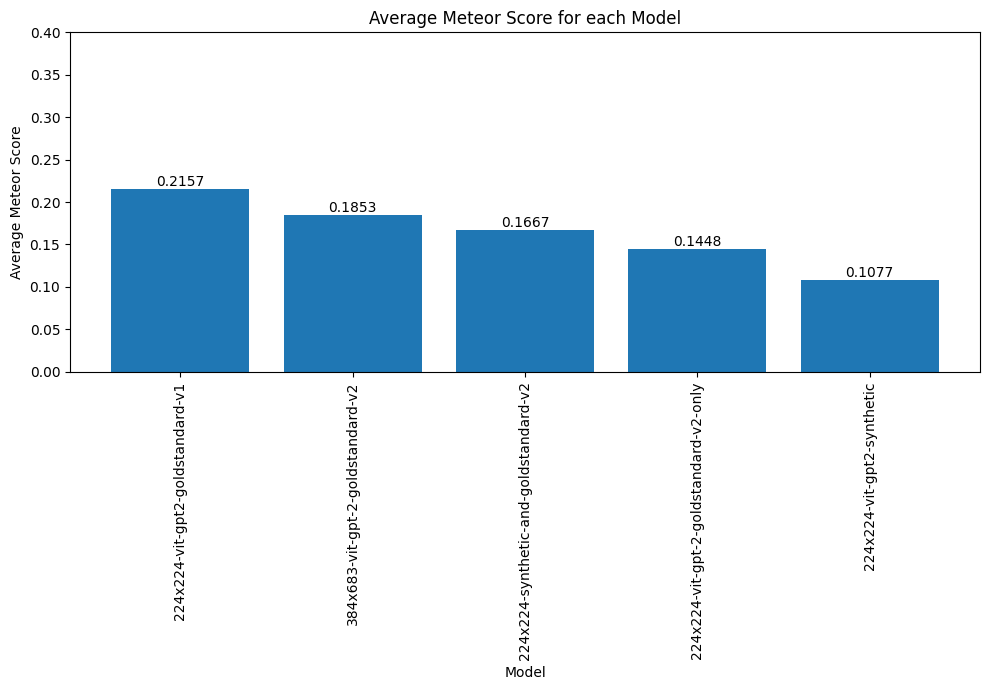

In [23]:
model_names = []
average_similarities = []

# Iterate through the subfolders in the main folder
for root, dirs, files in os.walk(folder_path):
    for dir_name in dirs:
        subfolder_path = os.path.join(root, dir_name)
        csv_path = os.path.join(subfolder_path, "sem_meteor.csv")

        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            average_similarity = df['sem_meteor'].mean()
            model_names.append(dir_name)
            average_similarities.append(average_similarity)

sort_indices = np.argsort(average_similarities)[::-1]
sorted_model_names = [model_names[i] for i in sort_indices]
sorted_average_similarities = [average_similarities[i] for i in sort_indices]

# Plotting the bar chart
plt.figure(figsize=(10,7))
plt.bar(sorted_model_names, sorted_average_similarities)
plt.xlabel("Model")
plt.ylabel("Average Meteor Score")
plt.title("Average Meteor Score for each Model")
plt.xticks(rotation=90)
# Add numerical values to each bar
for i, v in enumerate(sorted_average_similarities):
    plt.text(i, v, str(round(v, 4)), ha="center", va="bottom")

plt.ylim(0, 0.4)

plt.tight_layout()
plt.savefig("plots/vit_gpt_meteor_barplot.png", dpi=150)
plt.show()

- All training configs didn't perform well
- Interestingly, in terms of language quality, the increase in resolution did have a very slight positive effect
    - This hints at the fact that the image encoder did benefit slightly from the increase in resolution, yielding slightly better image representations.
- The best performing config was the training on the gold standard, (Do we describe this dataset as well?)
    - The reason for this could be, that the overall sample size is smaller and the domain of this dataset is strictly constrained to it-security. And thus, the distribution learned by the decoder is smaller as if the domain would be larger. As a result, the sentences produced by the decoder, more closely match the references, even though the image encoder didn't provide a valuable context. In other words, the probability of the decoder guessing correctly is higher than in a larger dataset.

### F1

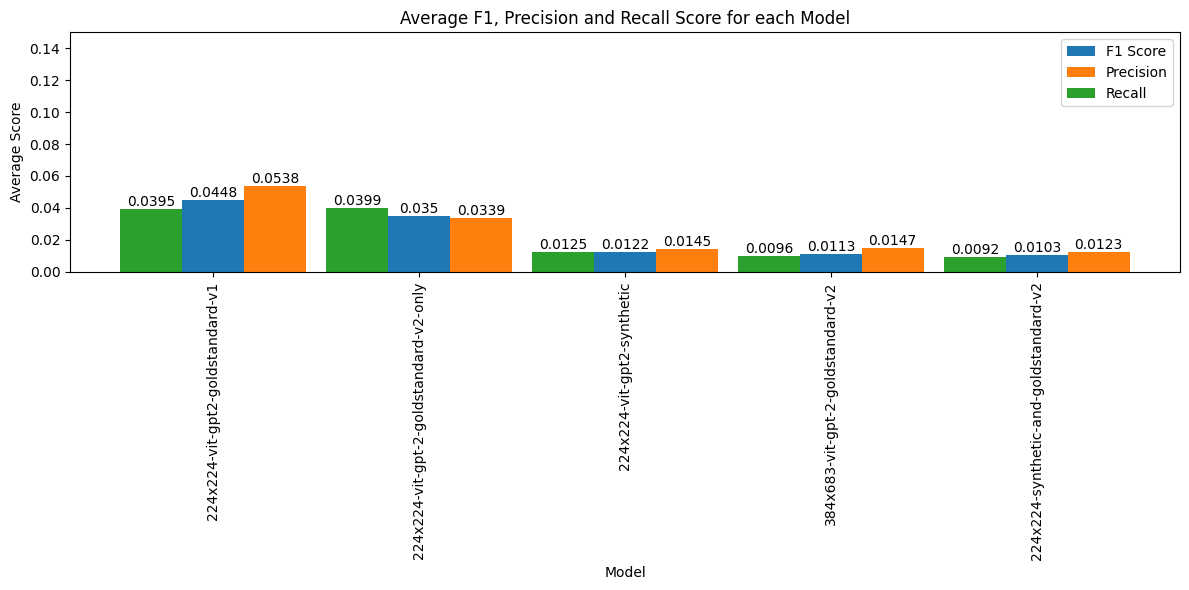

In [24]:
model_names = []
average_similarities = []
avg_ps = []
avg_rs = []

# Iterate through the subfolders in the main folder
for root, dirs, files in os.walk(folder_path):
    for dir_name in dirs:
        subfolder_path = os.path.join(root, dir_name)
        csv_path = os.path.join(subfolder_path, "traditional_scores.csv")

        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            average_similarity = df['f1'].mean()
            avg_p = df['p'].mean()
            avg_r = df['r'].mean()
            model_names.append(dir_name)
            average_similarities.append(average_similarity)
            avg_ps.append(avg_p)
            avg_rs.append(avg_r)

sort_indices = np.argsort(average_similarities)[::-1]
sorted_model_names = [model_names[i] for i in sort_indices]
sorted_average_similarities = [average_similarities[i] for i in sort_indices]
sorted_average_p = [avg_ps[i] for i in sort_indices]
sorted_average_r = [avg_rs[i] for i in sort_indices]

bar_width = 0.3
index = np.arange(len(sorted_model_names))

# Plotting the bar chart
plt.figure(figsize=(12,6))
plt.bar(index, sorted_average_similarities, bar_width, label="F1 Score")
plt.bar(index + bar_width, sorted_average_p, bar_width, label="Precision")
plt.bar(index - bar_width, sorted_average_r, bar_width, label="Recall")
plt.xlabel("Model")
plt.ylabel("Average Score")
plt.title("Average F1, Precision and Recall Score for each Model")
plt.xticks(index, sorted_model_names, rotation=90)
# Add numerical values to each bar
for i, v in enumerate(sorted_average_similarities):
    plt.text(i, v, str(round(v, 4)), ha="center", va="bottom")

for i, v in enumerate(sorted_average_p):
    plt.text(i + bar_width, v, str(round(v, 4)), ha="center", va="bottom")

for i, v in enumerate(sorted_average_r):
    plt.text(i - bar_width, v, str(round(v, 4)), ha="center", va="bottom")

plt.ylim(0, 0.15)

plt.tight_layout()
plt.legend()
plt.savefig("plots/vit_gpt_traditional_scores_f1_barplot.png", dpi=150)
plt.show()

- Basically the same as with semantic meteor, with the same reasons and observations.

### Conclusion

- Show model outputs, and use them to explain the results
- Synthetic slides performed the worst across the board, the dataset is probably just too noisy for its size
- Increasing the resolution didn't help overall
- The best model was trained on the small gold standard dataset, as the probability of the decoder guessing correctly is the highest because of its size and constraint domain
- The image encoder couldn't provide a good and meaningful representation of the images and with that the decoder has no useful context to use, and learns to ignore it
- Overall the model only learned to generate "What is / What are" questions and guesses the topic

#### Overall problem of ViT-GPT-2
- I referenced these facts here multiple times also in the other vit-gpt-2 notebook.
- The feature extractor / Image processor converts the input images into patches of patch size PxP which is 16x16 by default. the content of the patches is then mapped to the hidden_size through a trainable linear projection
- The resulting sequence length is directly dependent on the resolution.
- > for a resolution of 1080p this would correspond to a sequence length of 8.100 which the architecture can’t process because of memory constrains. Because of that most models have a max length of at most 1024 (GPT-2: 1024)
- The feature extractor resizes the images by default to the trained resolution of 224x224 -> To much information is lost because of that, as text is very sensitive to resolution -> show with an example
- > Resulting sequence length: 196
- If the resolution is increased, the positional embeddings get less meaningful as they are 2D-interpolated.
- In Addition to the resolution discussion, because the ViT architecture contains no inductive biases for 2D-Grid data such as Images, they have been found to not generalize well on insufficient amounts of training data. -> The original ViT has been trained on 14-300Million images.. our dataset is much much smaller but the data looks extremely different -> Lines up with our findings


## Overall
- Image-to-text models didn't perform at all
- Reason: The image encoders failed in all cases
    - The pretraining data is just too different to our tasks, and the size of our dataset wasn't sufficient to tune the models to properly process images of lecture slides
    - In order to make them work a larger amount of high quality training data is needed
    - Also an image-encoder pre-training on lecture slides / powerpoints or similar content could yield performance improvements